# Netflix Recommendation System

Eric Andrews, Maya Chalker, Katie Lawton

## Project Purpose

Using the Netflix dataset available through Kaggle, created a movie and television show recommendation system using 
natural language processing to identify sentiment and machine learning techniques such as TfidfVectorization and Cosine 
Similarities.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy

In [ ]:
data = pd.read_csv('netflix_titles.csv')

### EDA

In [ ]:
data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(docx):
    return sent_analyzer.polarity_scores(docx.text)

In [ ]:
!python -m spacy download en

2021-12-02 13:22:46.583975: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 13:22:46.584013: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 16.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
from spacy.tokens import Doc
Doc.set_extension("sentimenter",getter=sentiment_scores)

In [ ]:
data['description_sentiment_score'] = data['description'].apply(lambda x: nlp(x)._.sentimenter['compound'])

In [ ]:
data[['title','description','description_sentiment_score']].sort_values(by='description_sentiment_score', ascending=False)

,title,description,description_sentiment_score
4403,Medal of Honor,Honoring service members whose courage merited...,0.9709
7808,Qué pena tu serie,"Javier is happily in love with Sofia, so when ...",0.9657
733,LEGO Friends: The Power of Friendship,Five best friends face adventures side by side...,0.9647
648,Too Hot to Handle,"On the shores of paradise, gorgeous singles me...",0.9625
3442,The Spooky Tale of Captain Underpants Hack-a-ween,"When Melvin tries to cancel Halloween, clever ...",0.9606
...,...,...,...
4477,W/O Ram,Frustrated with the stalled investigation into...,-0.9648
3190,Cut Bank,A small-town dreamer is sure he's landed on a ...,-0.9668
1593,Kings of Jo'Burg,The Masire brothers rule Johannesburg's crimin...,-0.9694
3020,Soul Eater,Maka and the other students at the Death Weapo...,-0.9705


In [ ]:
data.description_sentiment_score.value_counts()

 0.0000    847
 0.4019    138
-0.3818    107
-0.5994    101
 0.4215    100
          ... 
 0.7745      1
 0.8847      1
-0.4295      1
 0.9099      1
 0.9278      1
Name: description_sentiment_score, Length: 796, dtype: int64

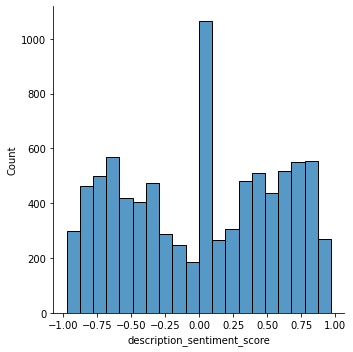

In [ ]:
sns.displot(data['description_sentiment_score'])

## Recommendation System

### Recommendation - Title

Term Frequency Inverse Document Frequency Vectorizer

formula used:  𝑡𝑓𝑖𝑑𝑓(𝑑,𝑡)=𝑡𝑓(𝑡)×𝑖𝑑𝑓(𝑑,𝑡) 
 - tf(t)= the term frequency is the number of times the term appears in the document
 - idf(d, t) = the document frequency is the number of documents 'd' that contain term 't'

Import the library and initialize the function.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

Clean up the description and fit the model to the data.

In [ ]:
#Replace NaN with an empty string
data['description'] = data['description'].fillna('')

#TF-IDF matrix by fitting and transforming using the called function above
tfidf_matrix = vectorizer.fit_transform(data['description'])

Calculate the cosine similarity

In [ ]:
#Linear Kernel
from sklearn.metrics.pairwise import linear_kernel

#linear kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Gather the unique titles

In [ ]:
indices = pd.Series(data.index, index = data['title']).drop_duplicates()

Define and call the function

In [ ]:
def recommender_title(title, cosine_sim=cosine_sim):
    idx = indices[title]
    
    #Get the pairwise similarity scores of all movies with that inputed title
    similiarity_scores = list(enumerate(cosine_sim[idx]))
        
    #Sort the movies based on the similarity scores from high to low
    similiarity_scores = sorted(similiarity_scores, key=lambda x:x[1], reverse=True)
    
    #Get the scores of the 10 most similar movies - the first one would be same title
    similiarity_scores = similiarity_scores[1:11]
    
    #Get the movie indices
    netflix_indices = [i[0] for i in similiarity_scores]
    
    info = []
    for i in similiarity_scores:
        info.append((data['title'].iloc[i[0]], i[1]))
    return info

recommender_title('Friends')

[('Manhattan Romance', 0.15237026907479903),
 ('BoJack Horseman', 0.15028953368141512),
 ('Things Heard & Seen', 0.14949271133327652),
 ('Episodes', 0.14853697304061317),
 ('Studio 54', 0.1424046010458695),
 ("Dad's Army", 0.14049027459152919),
 ('Trailer Park Boys', 0.13427085466841834),
 ('Single Ladies Senior', 0.1270081801514374),
 ('Why Are You Like This', 0.12494353136358004),
 ('Menahi', 0.12364054398185152)]

## Linear Regression

In [ ]:
# read in IMDB datasets
ratings = pd.read_csv('IMDb ratings.csv')
movie_names = pd.read_csv('IMDb movies.csv')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# merge datasets to get dataframe with just movie titles and weighted average IMDB score
rating_df = pd.merge(ratings[['imdb_title_id','weighted_average_vote']], 
                     movie_names[['imdb_title_id','title']], 
                     on = 'imdb_title_id', how = 'inner')
rating_df = rating_df.set_index('imdb_title_id')
rating_df

,weighted_average_vote,title
imdb_title_id,,
tt0000009,5.9,Miss Jerry
tt0000574,6.1,The Story of the Kelly Gang
tt0001892,5.8,Den sorte drøm
tt0002101,5.2,Cleopatra
tt0002130,7.0,L'Inferno
...,...,...
tt9908390,5.3,Le lion
tt9911196,7.7,De Beentjes van Sint-Hildegard
tt9911774,7.9,Padmavyuhathile Abhimanyu


In [ ]:
# merge IMDB and Netflix data
movie_ratings = pd.merge(data, rating_df, how = 'left', on = 'title')
movie_ratings

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,description_sentiment_score,weighted_average_vote
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",-0.2960,NaN
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",-0.1531,NaN
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,-0.7783,NaN
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",0.2263,NaN
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,0.7430,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9386,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",-0.2500,NaN
9387,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,-0.2732,NaN
9388,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",-0.6808,4.4
9389,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",-0.6808,6.1


In [ ]:
# only include rows that have a weighted average vote
movie_rating_df = movie_ratings[movie_ratings['weighted_average_vote'].isnull() == False]
movie_rating_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,description_sentiment_score,weighted_average_vote
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...,0.1280,2.4
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",-0.7845,6.9
15,s16,TV Show,Dear White People,NaN,"Logan Browning, Brandon P. Bell, DeRon Horton,...",United States,"September 22, 2021",2021,TV-MA,4 Seasons,"TV Comedies, TV Dramas",Students of color navigate the daily slights a...,0.0000,6.1
19,s20,TV Show,Jaguar,NaN,"Blanca Suárez, Iván Marcos, Óscar Casas, Adriá...",NaN,"September 22, 2021",2021,TV-MA,1 Season,"International TV Shows, Spanish-Language TV Sh...","In the 1960s, a Holocaust survivor joins a gro...",0.6369,5.5
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...,0.8176,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9384,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan","March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,0.0000,6.7
9385,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",-0.6808,7.7
9388,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",-0.6808,4.4
9389,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",-0.6808,6.1


In [ ]:
!pip install statsmodels==0.13.1

     |████████████████████████████████| 9.8 MB 22.5 MB/s 
     |████████████████████████████████| 233 kB 55.0 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model = smf.ols("weighted_average_vote ~ description_sentiment_score ", data=movie_rating_df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     weighted_average_vote   R-squared:                       0.003
Model:                               OLS   Adj. R-squared:                  0.003
Method:                    Least Squares   F-statistic:                     9.515
Date:                   Thu, 02 Dec 2021   Prob (F-statistic):            0.00206
Time:                           13:26:12   Log-Likelihood:                -4919.6
No. Observations:                   2960   AIC:                             9843.
Df Residuals:                       2958   BIC:                             9855.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       5.9144      0.024    246.908      0.000       5.867       5.961
description_sentiment_score     0.1294      0.042      3.085      0.002       0.047       0.212
==============================================================================
Omnibus:                      107.152   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.295
Skew:                          -0.488   Prob(JB):                     2.05e-26
Kurtosis:                       3.079   Cond. No.                         1.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- R^2 value is very small so the data is highly variable 
- P-value is less than 0.05 so we should reject the null hypothesis (no significant relationship) and conclude that there is a significant relationship between IMDB score and description sentiment. 
- Independent variables are correlated with the dependent variable, but they do not explain much of the variability in the dependent variable.
https://statisticsbyjim.com/regression/low-r-squared-regression/

Text(0.5, 1.0, 'Linear Regression Plot of Description Sentiment vs IMDB Rating')

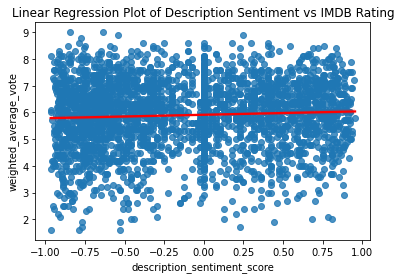

In [ ]:
sns.regplot(x="description_sentiment_score", y="weighted_average_vote", data=movie_rating_df, line_kws={"color": "red"})
plt.title('Linear Regression Plot of Description Sentiment vs IMDB Rating')


## Limitations/Challenges

* Null Values
    - Director, Cast, country, date added, rating, and duration
    - Description had no null values, which is what we needed for recommendation system, so null values ended up being an easy obstacle to overcome
        - Filled with empty strings, N/A, Mode
* Incorrect Input of Data
    - i.e.) Movie Lengths inputted into Rating Column
    - Data had to be translated and cleaned into usable types for machine learning model and linear regression
* IMBD Rating Dataset
    - Did not have all titles found in Netflix dataset, so analysis may not be representative of entire dataset; regression should cautiously extrapolated to entire set
        - Netflix dataset --> 6131 titles
        - Merged dataset --> 2960 titles

## Recommendations

* Deal with Null Values More Efficiently
    - Reference other datasets and merge with original dataset in order to obtain necessary information to proceed with analysis/recommendations
* Refine Recommendation System
    - Currently based on similarities between descriptions of titles
    - Future iterations can recommend based on cast, ratings, or even location of production
    - By incorporating different factors, recommender system could be more accurate in its suggestions

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9418010-a4f3-43dc-9b03-c6e40b911e74' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>